#[UCI Heart Disease Data](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data)(Kaggle) - klasyfikacja choroby serca



In [11]:
import kagglehub
import os
import pandas as pd

path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

print("Path to dataset files:", path)
print(os.listdir(path))

df = pd.read_csv(os.path.join(path, "heart_disease_uci.csv"))

df.head()

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Path to dataset files: /kaggle/input/heart-disease-data
['heart_disease_uci.csv']


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


#Wymiary
Rekordy: 920
Kolumny: 16 cech

#Opis cech:

###Numeryczne (int64 / float64): 8 kolumn

id – unikalny identyfikator pacjenta

age – wiek pacjenta

trestbps – ciśnienie krwi w spoczynku

chol – cholesterol w mg/dl

thalach – maksymalne tętno osiągnięte

oldpeak – ST depression wywołane wysiłkiem

ca – liczba naczyń głównych pokolorowanych fluoroskopowo

num – przewidywana etykieta choroby serca


###Kategoryczne / obiektowe (object): 8 kolumn

sex – płeć

dataset – pochodzenie badania

cp – typ bólu w klatce piersiowej

fbs – cukier na czczo > 120 mg/dl (True/False)

restecg – wynik EKG w spoczynku

exang – dławica wywołana wysiłkiem

slope – nachylenie ST segment

thal – typ defektu (normal, fixed defect, reversible defect)


###Brakujące dane

trestbps – 861/920 → ok. 6.4% braków

chol – 890/920 → ok. 3.3% braków

fbs – 830/920 → ok. 9.8% braków

slope – 611/920 → ok. 33.5% braków

ca – 309/920 → ok. 66.4% braków

thal – 434/920 → ok. 52.8% braków

In [13]:
n_rows, n_cols = df.shape
print(f"\nLiczba rekordów: {n_rows}")
print(f"Liczba cech (kolumn): {n_cols}")

print("\n--- Przykładowe wiersze ---")
print(df.head())

print("\n--- Statystyki opisowe ---")
print(df.describe())



Liczba rekordów: 920
Liczba cech (kolumn): 16

--- Przykładowe wiersze ---
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable de

In [14]:
import numpy as np

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

target_col = 'num' if 'num' in df.columns else None

if target_col:
    if target_col in num_cols:
        num_cols.remove(target_col)
    if target_col in cat_cols:
        cat_cols.remove(target_col)

print("Kolumny numeryczne:", num_cols)
print("Kolumny kategoryczne:", cat_cols)
print("Zmienna docelowa:", target_col)


Kolumny numeryczne: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Kolumny kategoryczne: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
Zmienna docelowa: num


In [15]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer

num_df = df[num_cols].copy()
cat_df = df[cat_cols].copy()

half = len(num_cols) // 2
num_easy = num_cols[:half]
num_hard = num_cols[half:]

simple_imputer = SimpleImputer(strategy='mean')
num_easy_imputed = pd.DataFrame(simple_imputer.fit_transform(df[num_easy]), columns=num_easy)

knn_imputer = KNNImputer(n_neighbors=5)
num_hard_imputed = pd.DataFrame(knn_imputer.fit_transform(df[num_hard]), columns=num_hard)

num_imputed = pd.concat([num_easy_imputed, num_hard_imputed], axis=1)

cat_imputer = SimpleImputer(strategy='most_frequent')
cat_imputed = pd.DataFrame(cat_imputer.fit_transform(cat_df), columns=cat_cols)

df_imputed = pd.concat([num_imputed, cat_imputed], axis=1)

print("✅ Dane uzupełnione:")
print(df_imputed.info())

✅ Dane uzupełnione:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    float64
 1   age       920 non-null    float64
 2   trestbps  920 non-null    float64
 3   chol      920 non-null    float64
 4   thalch    920 non-null    float64
 5   oldpeak   920 non-null    float64
 6   ca        920 non-null    float64
 7   sex       920 non-null    object 
 8   dataset   920 non-null    object 
 9   cp        920 non-null    object 
 10  fbs       920 non-null    object 
 11  restecg   920 non-null    object 
 12  exang     920 non-null    object 
 13  slope     920 non-null    object 
 14  thal      920 non-null    object 
dtypes: float64(7), object(8)
memory usage: 107.9+ KB
None


In [16]:
from sklearn.preprocessing import OrdinalEncoder

df_encoded = df_imputed.copy()

ordinal_features = {
    'cp': ['asymptomatic', 'non-anginal', 'atypical angina', 'typical angina'],
    'restecg': ['normal', 'st-t abnormality', 'lv hypertrophy'],
    'slope': ['upsloping', 'flat', 'downsloping'],
    'thal': ['normal', 'reversable defect', 'fixed defect']
}

encoder = OrdinalEncoder(categories=[ordinal_features[col] for col in ordinal_features])
df_encoded[list(ordinal_features.keys())] = encoder.fit_transform(df_encoded[list(ordinal_features.keys())])

nominal_features = ['sex', 'dataset', 'fbs', 'exang']
df_encoded = pd.get_dummies(df_encoded, columns=nominal_features, drop_first=True)

print("✅ Wszystkie kolumny zakodowane numerycznie:")
print(df_encoded.info())
df_encoded.head()


✅ Wszystkie kolumny zakodowane numerycznie:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     920 non-null    float64
 1   age                    920 non-null    float64
 2   trestbps               920 non-null    float64
 3   chol                   920 non-null    float64
 4   thalch                 920 non-null    float64
 5   oldpeak                920 non-null    float64
 6   ca                     920 non-null    float64
 7   cp                     920 non-null    float64
 8   restecg                920 non-null    float64
 9   slope                  920 non-null    float64
 10  thal                   920 non-null    float64
 11  sex_Male               920 non-null    bool   
 12  dataset_Hungary        920 non-null    bool   
 13  dataset_Switzerland    920 non-null    bool   
 14  dataset_VA Lon

,id,age,trestbps,chol,thalch,oldpeak,ca,cp,restecg,slope,thal,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,fbs_True,exang_True
0,1.0,63.0,145.0,233.0,150.0,2.3,0.0,3.0,2.0,2.0,2.0,True,False,False,False,True,False
1,2.0,67.0,160.0,286.0,108.0,1.5,3.0,0.0,2.0,1.0,0.0,True,False,False,False,False,True
2,3.0,67.0,120.0,229.0,129.0,2.6,2.0,0.0,2.0,1.0,1.0,True,False,False,False,False,True
3,4.0,37.0,130.0,250.0,187.0,3.5,0.0,1.0,0.0,2.0,0.0,True,False,False,False,False,False
4,5.0,41.0,130.0,204.0,172.0,1.4,0.0,2.0,2.0,0.0,0.0,False,False,False,False,False,False


Utworzone poniżej cechy(ekstrakcja):

cv_risk_score – zagregowany wskaźnik ryzyka sercowo-naczyniowego (łączący wiek, cholesterol, ciśnienie i depresję ST).

heart_reserve – wskaźnik wydolności serca (thalach względem oldpeak).

age_category – kategoria wiekowa (0–3).

triple_risk – flaga potrójnego ryzyka (chol > 240, ciśnienie > 140, wiek > 55).

exercise_tolerance – wskaźnik tolerancji wysiłku (skalowany 0–5).

In [17]:
if 'num' not in df_encoded.columns and 'num' in df.columns:
    df_encoded['num'] = df['num']

In [18]:
# 1. Cardiovascular Risk Score
df_encoded['cv_risk_score'] = (
    (df_encoded['age'] - 40) * 0.1 +
    (df_encoded['chol'] - 200) * 0.05 +
    (df_encoded['trestbps'] - 120) * 0.08 +
    df_encoded['oldpeak'] * 2
).clip(lower=0)

# 2. Heart Reserve Capacity
df_encoded['heart_reserve'] = df_encoded['thalch'] / (df_encoded['oldpeak'] + 1)

# 3. Age Category
df_encoded['age_category'] = pd.cut(
    df_encoded['age'],
    bins=[0, 45, 55, 65, 100],
    labels=[0, 1, 2, 3]
).astype(float)

# 4. Triple Risk Flag
df_encoded['triple_risk'] = (
    (df_encoded['chol'] > 240) &
    (df_encoded['trestbps'] > 140) &
    (df_encoded['age'] > 55)
).astype(int)

# 5. Exercise Tolerance Score
df_encoded['exercise_tolerance'] = (
    (df_encoded['thalch'] > 150).astype(int) * 2 +
    (df_encoded['oldpeak'] < 1).astype(int) * 2 +
    (~df_encoded['exang_True']).astype(int)
)

cols_to_display = [
    'age', 'trestbps', 'chol', 'thalch', 'oldpeak',  # kluczowe oryginalne
    'cv_risk_score', 'heart_reserve', 'age_category',
    'triple_risk', 'exercise_tolerance', 'num'        # wszystkie nowe + target
]

print("Dodano 5 nowych cech. Aktualna liczba kolumn:", len(df_encoded.columns))
df_encoded[cols_to_display].head()

Dodano 5 nowych cech. Aktualna liczba kolumn: 23


,age,trestbps,chol,thalch,oldpeak,cv_risk_score,heart_reserve,age_category,triple_risk,exercise_tolerance,num
0,63.0,145.0,233.0,150.0,2.3,10.55,45.454545,2.0,0,1,0
1,67.0,160.0,286.0,108.0,1.5,13.20,43.200000,3.0,1,0,2
2,67.0,120.0,229.0,129.0,2.6,9.35,35.833333,3.0,0,0,1
3,37.0,130.0,250.0,187.0,3.5,10.00,41.555556,0.0,0,3,0
4,41.0,130.0,204.0,172.0,1.4,3.90,71.666667,0.0,0,3,0


#Imputacja i kodowanie

1. **Imputacja braków**  
   - Dane numeryczne podzielono na dwa podzbiory:
     - Podzbiór A: imputacja prostą metodą (średnia)  
     - Podzbiór B: imputacja bardziej zaawansowaną metodą (KNNImputer)  
   - Dla danych kategorycznych zastosowano imputację wartościami najczęstszymi (`most_frequent`).

2. **Kodowanie zmiennych kategorycznych**  
   - Zmienne z naturalnym porządkiem (np. `cp`, `restecg`, `slope`, `thal`) zakodowano za pomocą **OrdinalEncoder**, by zachować sens kolejności.  
   - Pozostałe zmienne nominalne (np. `sex`, `dataset`, `fbs`, `exang`) zakodowano metodą **One-Hot Encoding**, usuwając jedną referencyjną kategorię (drop_first=True), aby uniknąć współliniowości.

Po tych operacjach wszystkie cechy mają typ numeryczny (float lub bool), bez brakujących wartości — dane są gotowe do analizy statystycznej i modelowania.  


### Zmodyfikowane i zakodowane cechy

1. **`sex`** → zastąpiono przez kolumnę binarną `sex_Male`  
   - Wartość `True` oznacza mężczyznę, `False` – kobietę.  

2. **`dataset`** → zastąpiono trzema kolumnami logicznymi:  
   - `dataset_Hungary`, `dataset_Switzerland`, `dataset_VA Long Beach`  
   - Brak wartości w tych kolumnach (wszystkie `False`) oznacza dane z **Cleveland** (usunięta referencja po One-Hot Encoding).

3. **`cp` (chest pain type)** → zakodowano liczbowo metodą **OrdinalEncoder**:  
   - 0 – typical angina  
   - 1 – atypical angina  
   - 2 – non-anginal  
   - 3 – asymptomatic  

4. **`restecg`** → zakodowano liczbowo metodą **OrdinalEncoder**:  
   - 0 – normal  
   - 1 – stt abnormality  
   - 2 – lv hypertrophy  

5. **`slope`** → zakodowano liczbowo metodą **OrdinalEncoder**:  
   - 0 – upsloping  
   - 1 – flat  
   - 2 – downsloping  

6. **`thal`** → zakodowano liczbowo metodą **OrdinalEncoder**:  
   - 0 – normal  
   - 1 – fixed defect  
   - 2 – reversible defect  

7. **`fbs` i `exang`** → zastąpione przez kolumny binarne (`fbs_True`, `exang_True`)  
   - Wartość `True` oznacza odpowiednio: cukier na czczo >120 mg/dl / wystąpienie dławicy przy wysiłku.


Wszystkie pozostałe kolumny (`age`, `trestbps`, `chol`, `thalch`, `oldpeak`, `ca`) zachowały oryginalną postać liczbową (float), jedynie uzupełniono w nich brakujące wartości.


In [19]:
display(df_encoded.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,920.0,460.500000,265.725422,1.0,230.7500,460.500,690.2500,920.00
age,920.0,53.510870,9.424685,28.0,47.0000,54.000,60.0000,77.00
trestbps,920.0,132.132404,18.443895,0.0,120.0000,130.000,140.0000,200.00
chol,920.0,198.807164,109.530653,0.0,175.0000,223.000,267.0000,603.00
thalch,920.0,137.773301,25.368365,60.0,120.0000,140.000,157.0000,202.00
oldpeak,920.0,0.873213,1.062896,-2.6,0.0000,0.500,1.5000,6.20
ca,920.0,0.763293,0.669795,0.0,0.2000,0.800,1.2000,3.00
cp,920.0,0.750000,0.930969,0.0,0.0000,0.000,1.0000,3.00
restecg,920.0,0.603261,0.805443,0.0,0.0000,0.000,1.0000,2.00
slope,920.0,0.847826,0.516007,0.0,1.0000,1.000,1.0000,2.00


In [20]:
# Rozkład wieku pacjentów + średni cholesterol w tych przedziałach
print("\n=== Rozkład wieku pacjentów ===")
age_bins = pd.cut(df_encoded['age'], bins=5)
age_distribution = df_encoded['age'].value_counts(bins=5).sort_index()

print("Liczba pacjentów w przedziałach wiekowych:")
print(age_distribution)

print("\nŚredni cholesterol (chol) w tych samych przedziałach wiekowych:")
print(df_encoded.groupby(age_bins)['chol'].mean().round(2))



=== Rozkład wieku pacjentów ===
Liczba pacjentów w przedziałach wiekowych:
(27.95, 37.8]     49
(37.8, 47.6]     190
(47.6, 57.4]     350
(57.4, 67.2]     277
(67.2, 77.0]      54
Name: count, dtype: int64

Średni cholesterol (chol) w tych samych przedziałach wiekowych:
age
(27.951, 37.8]    210.98
(37.8, 47.6]      211.55
(47.6, 57.4]      203.84
(57.4, 67.2]      186.22
(67.2, 77.0]      174.87
Name: chol, dtype: float64


/tmp/ipython-input-2671056806.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_encoded.groupby(age_bins)['chol'].mean().round(2))


In [21]:
# Średnie wartości ciśnienia i cholesterolu w zależności od kraju pochodzenia
print("\n=== Średnie ciśnienie i cholesterol w zależności od kraju ===")
country_cols = ['dataset_Hungary', 'dataset_Switzerland', 'dataset_VA Long Beach']
df_encoded['dataset_origin'] = df_encoded[country_cols].idxmax(axis=1).replace({
    'dataset_Hungary': 'Hungary',
    'dataset_Switzerland': 'Switzerland',
    'dataset_VA Long Beach': 'VA Long Beach'
})
df_encoded.loc[(df_encoded[country_cols] == False).all(axis=1), 'dataset_origin'] = 'Cleveland'
print(df_encoded.groupby('dataset_origin')[['trestbps', 'chol']].mean().round(2))


=== Średnie ciśnienie i cholesterol w zależności od kraju ===
                trestbps    chol
dataset_origin                  
Cleveland         131.68  246.32
Hungary           132.59  246.91
Switzerland       130.24    0.00
VA Long Beach     133.31  178.40


In [22]:
print("\n=== Średnie tętno maksymalne (thalch) w zależności od płci ===")
print(df_encoded.groupby('sex_Male')['thalch'].mean().rename({True: "Mężczyźni", False: "Kobiety"}))


=== Średnie tętno maksymalne (thalch) w zależności od płci ===
sex_Male
Kobiety      146.117526
Mężczyźni    135.543577
Name: thalch, dtype: float64


In [23]:
# Częstość występowania dławicy wysiłkowej (exang) w zależności od płci
print("\n=== Dławica wysiłkowa (exang_True) w zależności od płci ===")
print(df_encoded.groupby('sex_Male')['exang_True'].mean().rename({True: "Mężczyźni", False: "Kobiety"}))


=== Dławica wysiłkowa (exang_True) w zależności od płci ===
sex_Male
Kobiety      0.221649
Mężczyźni    0.404959
Name: exang_True, dtype: float64


In [25]:
print("=== Średni wiek pacjentów z chorobą i bez choroby, z podziałem na płeć ===")

# Obliczamy średni wiek pacjentów z chorobą i bez choroby (num > 0 oznacza obecność choroby)
age_by_sex_disease = df_encoded.groupby(['sex_Male', df_encoded['num'] > 0])['age'].mean().unstack()
age_by_sex_disease.columns = ['Brak choroby', 'Choroba serca']
age_by_sex_disease.index = ['Kobiety', 'Mężczyźni']
print(age_by_sex_disease.round(1))

# Udział przypadków choroby w każdej grupie płci
print("\n=== Odsetek osób z chorobą serca w zależności od płci ===")
disease_rate_by_sex = df_encoded.groupby('sex_Male')['num'].apply(lambda x: (x > 0).mean())
disease_rate_by_sex.index = ['Kobiety', 'Mężczyźni']
print((disease_rate_by_sex * 100).round(1).astype(str) + '%')


=== Średni wiek pacjentów z chorobą i bez choroby, z podziałem na płeć ===
           Brak choroby  Choroba serca
Kobiety            51.2           56.2
Mężczyźni          50.2           55.9

=== Odsetek osób z chorobą serca w zależności od płci ===
Kobiety      25.8%
Mężczyźni    63.2%
Name: num, dtype: object


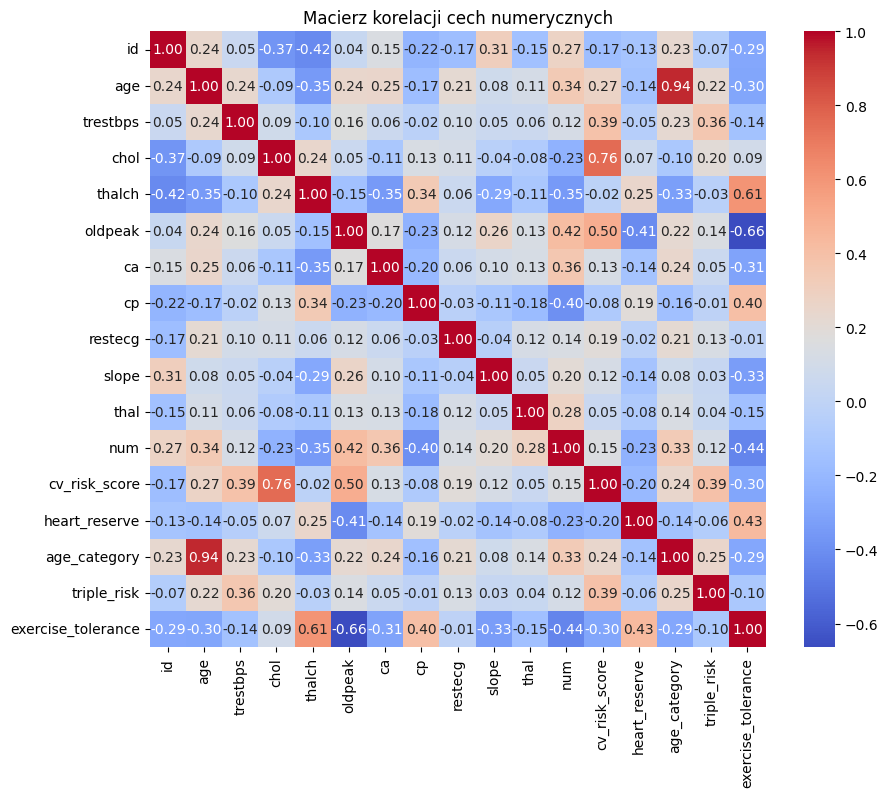

In [26]:
import seaborn as sns #niżej jest kolejna to chyba usunąć
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
corr_matrix = df_encoded.select_dtypes(include='number').corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Macierz korelacji cech numerycznych")
plt.show()


Liczba cech: 15
Cechy: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'cp', 'restecg', 'slope', 'thal', 'cv_risk_score', 'heart_reserve', 'age_category', 'triple_risk', 'exercise_tolerance']



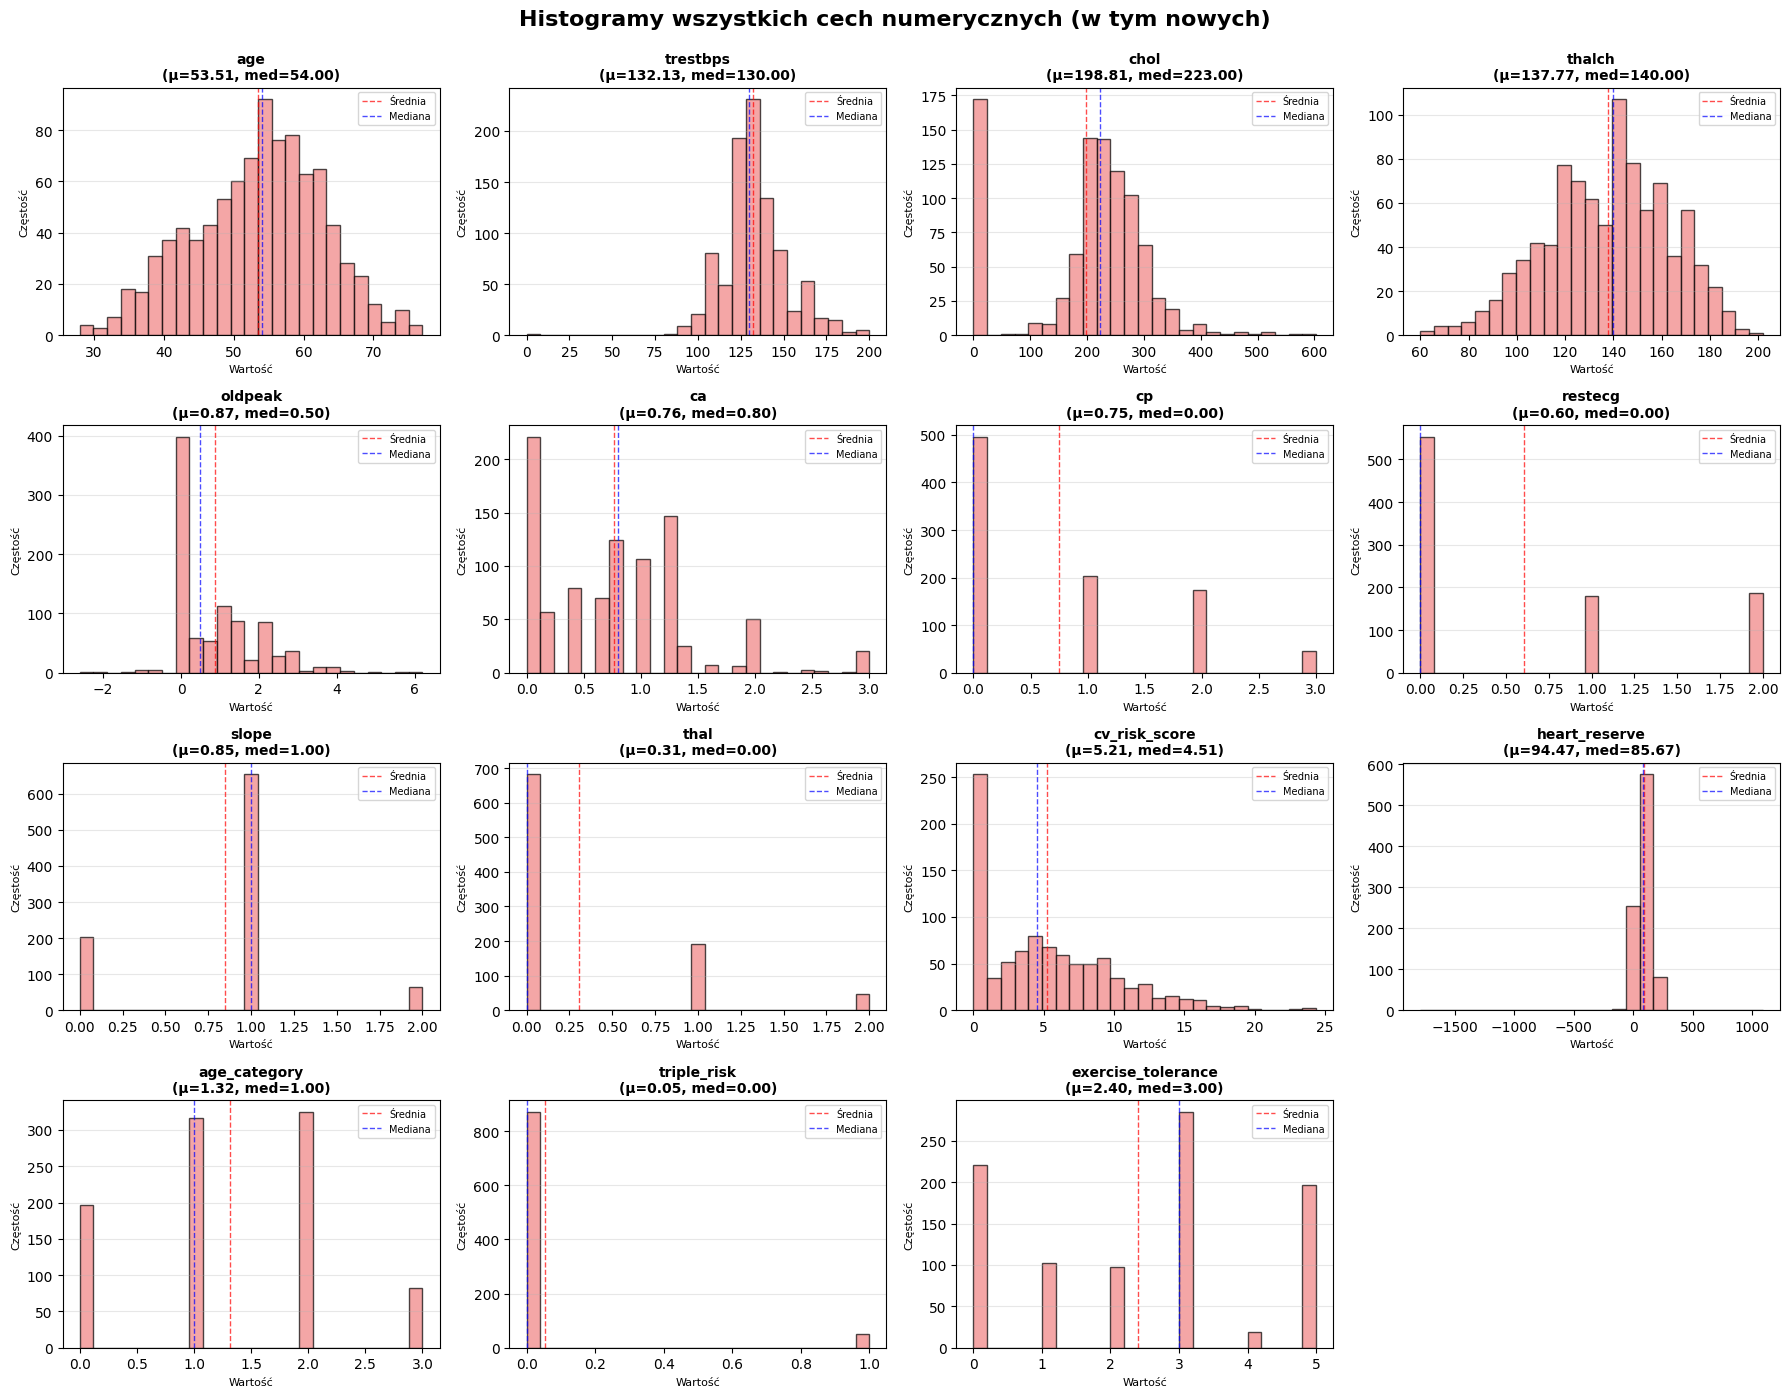

In [27]:
# HISTOGRAMY CECH NUMERYCZNYCH
# Wizualizacja rozkładu wszystkich cech numerycznych, w tym cech po ekstrakcji

import matplotlib.pyplot as plt
import numpy as np

numeric_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()
cols_to_exclude = ['id', 'num']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

# Sprawdzenie i zastąpienie wartości nieskończonych
for col in numeric_cols:
    if np.isinf(df_encoded[col]).any():
        df_encoded[col] = df_encoded[col].replace([np.inf, -np.inf], np.nan)

print(f"Liczba cech: {len(numeric_cols)}")
print(f"Cechy: {numeric_cols}\n")

# Ustawienia siatki
n_cols_plot = 4
n_rows_plot = int(np.ceil(len(numeric_cols) / n_cols_plot))

fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(18, n_rows_plot * 3.5))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    data = df_encoded[col].dropna()

    if len(data) == 0:
        axes[idx].text(0.5, 0.5, f'{col}\n(brak danych)',
                       ha='center', va='center', fontsize=10)
        axes[idx].set_title(col, fontsize=10, fontweight='bold')
        continue

    axes[idx].hist(data, bins=25, color='lightcoral', edgecolor='black', alpha=0.7)
    mean_val, median_val = data.mean(), data.median()

    axes[idx].set_title(f'{col}\n(μ={mean_val:.2f}, med={median_val:.2f})',
                        fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Wartość', fontsize=8)
    axes[idx].set_ylabel('Częstość', fontsize=8)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Średnia')
    axes[idx].axvline(median_val, color='blue', linestyle='--', linewidth=1, alpha=0.7, label='Mediana')
    axes[idx].legend(fontsize=7, loc='upper right')

for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle("Histogramy wszystkich cech numerycznych (w tym nowych)", fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


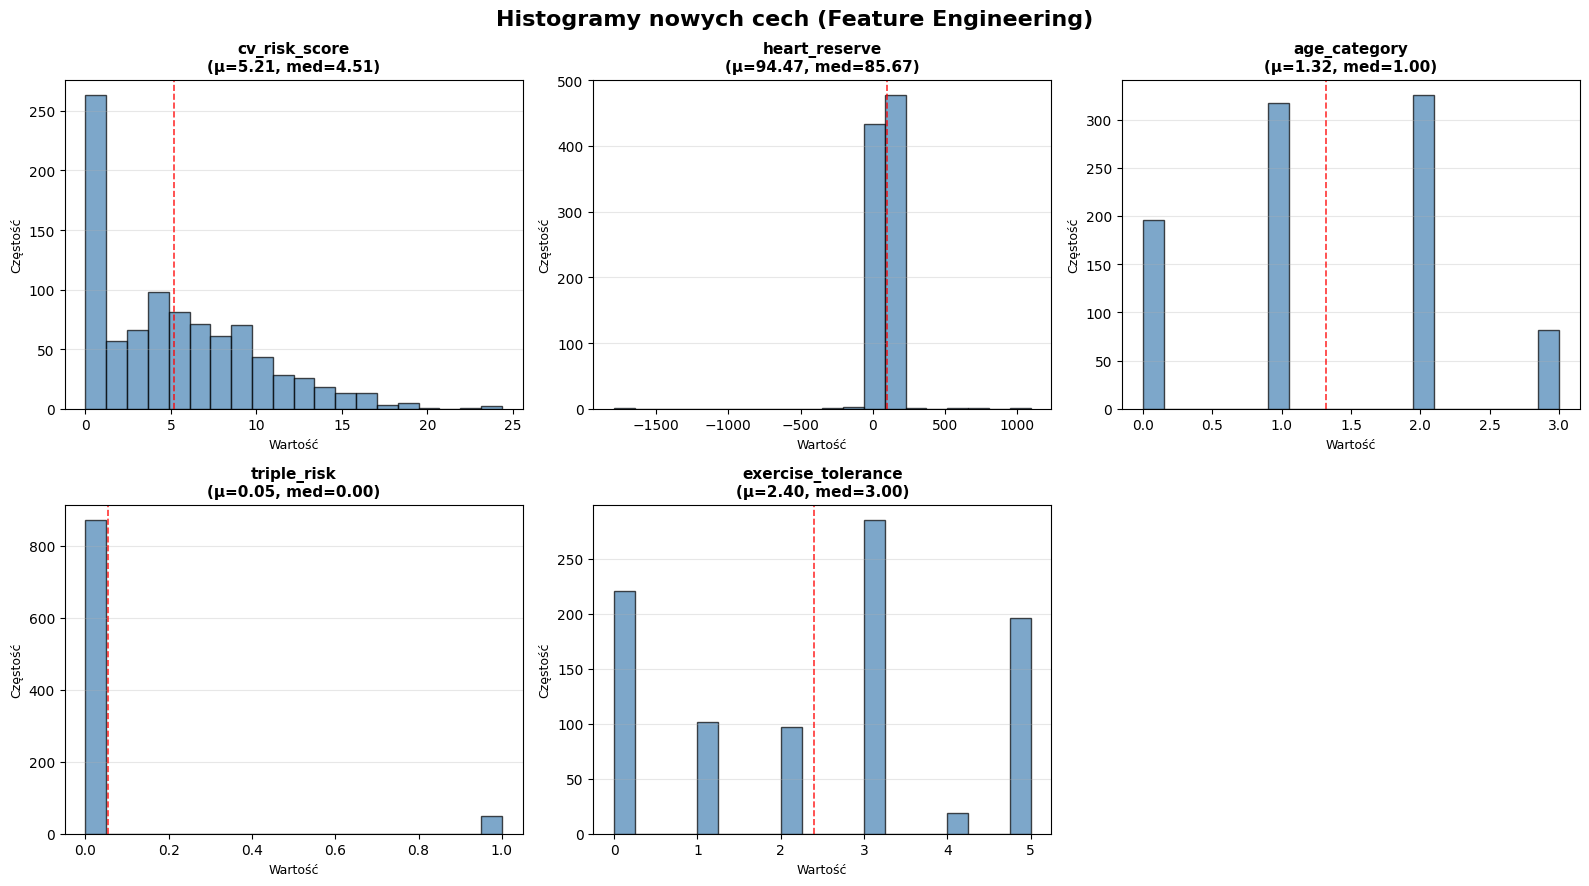


Statystyki opisowe dla nowych cech:
                    count   mean    std     min    25%    50%     75%      max
cv_risk_score       920.0   5.21   4.69     0.0   0.43   4.51    8.39    24.35
heart_reserve       918.0  94.47  90.08 -1790.0  50.00  85.67  140.00  1090.00
age_category        920.0   1.32   0.91     0.0   1.00   1.00    2.00     3.00
triple_risk         920.0   0.05   0.22     0.0   0.00   0.00    0.00     1.00
exercise_tolerance  920.0   2.40   1.80     0.0   1.00   3.00    3.00     5.00


In [28]:
# HISTOGRAMY NOWYCH CECH (Feature Engineering)
# Wizualizacja rozkładów nowych cech oraz statystyki opisowe

new_features = ['cv_risk_score', 'heart_reserve', 'age_category', 'triple_risk', 'exercise_tolerance']
existing_new_features = [f for f in new_features if f in df_encoded.columns]

if existing_new_features:
    fig, axes = plt.subplots(2, 3, figsize=(16, 9))
    axes = axes.flatten()

    for idx, col in enumerate(existing_new_features):
        data = df_encoded[col].replace([np.inf, -np.inf], np.nan).dropna()
        if len(data) == 0:
            axes[idx].text(0.5, 0.5, f'{col}\n(brak danych)',
                          ha='center', va='center', fontsize=10)
            continue

        axes[idx].hist(data, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
        mean_val, median_val = data.mean(), data.median()

        axes[idx].set_title(f'{col}\n(μ={mean_val:.2f}, med={median_val:.2f})',
                            fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Wartość', fontsize=9)
        axes[idx].set_ylabel('Częstość', fontsize=9)
        axes[idx].grid(axis='y', alpha=0.3)
        axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=1.2, alpha=0.8)

    fig.delaxes(axes[-1])
    plt.suptitle("Histogramy nowych cech (Feature Engineering)", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\nStatystyki opisowe dla nowych cech:")
    new_features_clean = df_encoded[existing_new_features].replace([np.inf, -np.inf], np.nan)
    print(new_features_clean.describe().T.round(2))


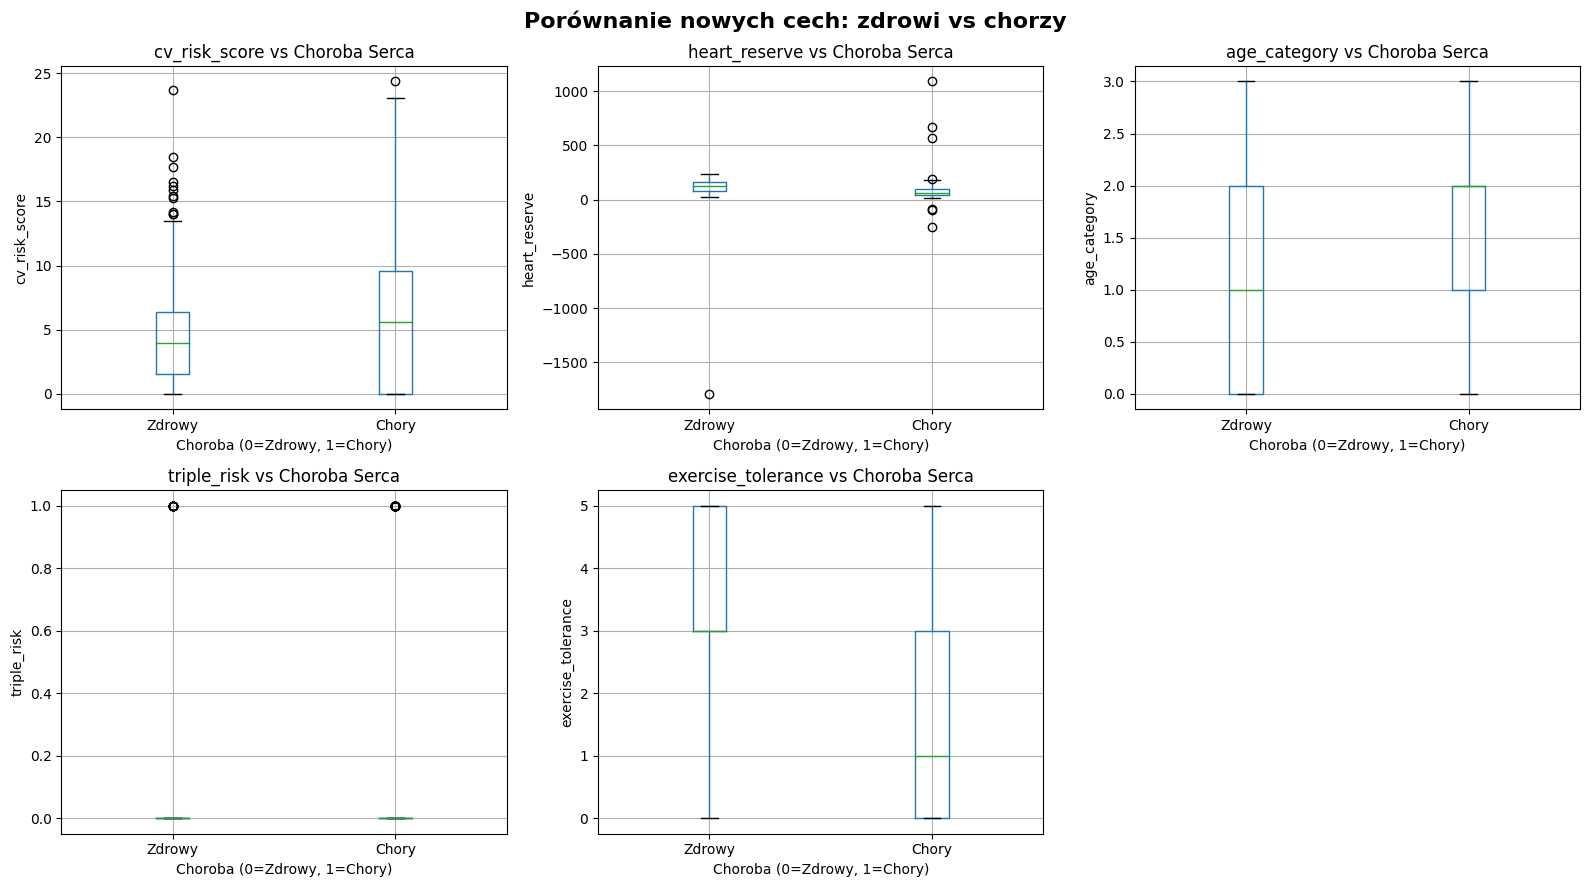


Średnie wartości nowych cech w grupach (zdrowi vs chorzy):
                cv_risk_score  heart_reserve  age_category  triple_risk  \
Zdrowi (num=0)           4.47         116.87          1.02         0.03   
Chorzy (num>0)           5.80          76.31          1.56         0.07   

                exercise_tolerance  
Zdrowi (num=0)                3.40  
Chorzy (num>0)                1.59  


In [29]:
# PORÓWNANIE NOWYCH CECH WZGLĘDEM OBECNOŚCI CHOROBY
# Boxploty oraz średnie wartości cech dla grup: zdrowi vs chorzy

if 'num' in df_encoded.columns:

    df_encoded['has_disease'] = (df_encoded['num'] > 0).astype(int)

    fig, axes = plt.subplots(2, 3, figsize=(16, 9))
    axes = axes.flatten()

    for idx, col in enumerate(existing_new_features):
        plot_data = df_encoded[[col, 'has_disease']].copy()
        plot_data[col] = plot_data[col].replace([np.inf, -np.inf], np.nan)
        plot_data = plot_data.dropna()

        if len(plot_data) == 0:
            axes[idx].text(0.5, 0.5, f'{col}\n(brak danych)',
                          ha='center', va='center', fontsize=10)
            continue

        plot_data.boxplot(column=col, by='has_disease', ax=axes[idx])
        axes[idx].set_title(f'{col} vs Choroba Serca')
        axes[idx].set_xlabel('Choroba (0=Zdrowy, 1=Chory)')
        axes[idx].set_ylabel(col)
        plt.sca(axes[idx])
        plt.xticks([1, 2], ['Zdrowy', 'Chory'])

    fig.delaxes(axes[-1])
    plt.suptitle("Porównanie nowych cech: zdrowi vs chorzy", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\nŚrednie wartości nowych cech w grupach (zdrowi vs chorzy):")
    clean_features = df_encoded[existing_new_features].replace([np.inf, -np.inf], np.nan)
    df_temp = pd.concat([clean_features, df_encoded[['has_disease']]], axis=1)
    comparison = df_temp.groupby('has_disease')[existing_new_features].mean()
    comparison.index = ['Zdrowi (num=0)', 'Chorzy (num>0)']
    print(comparison.round(2))


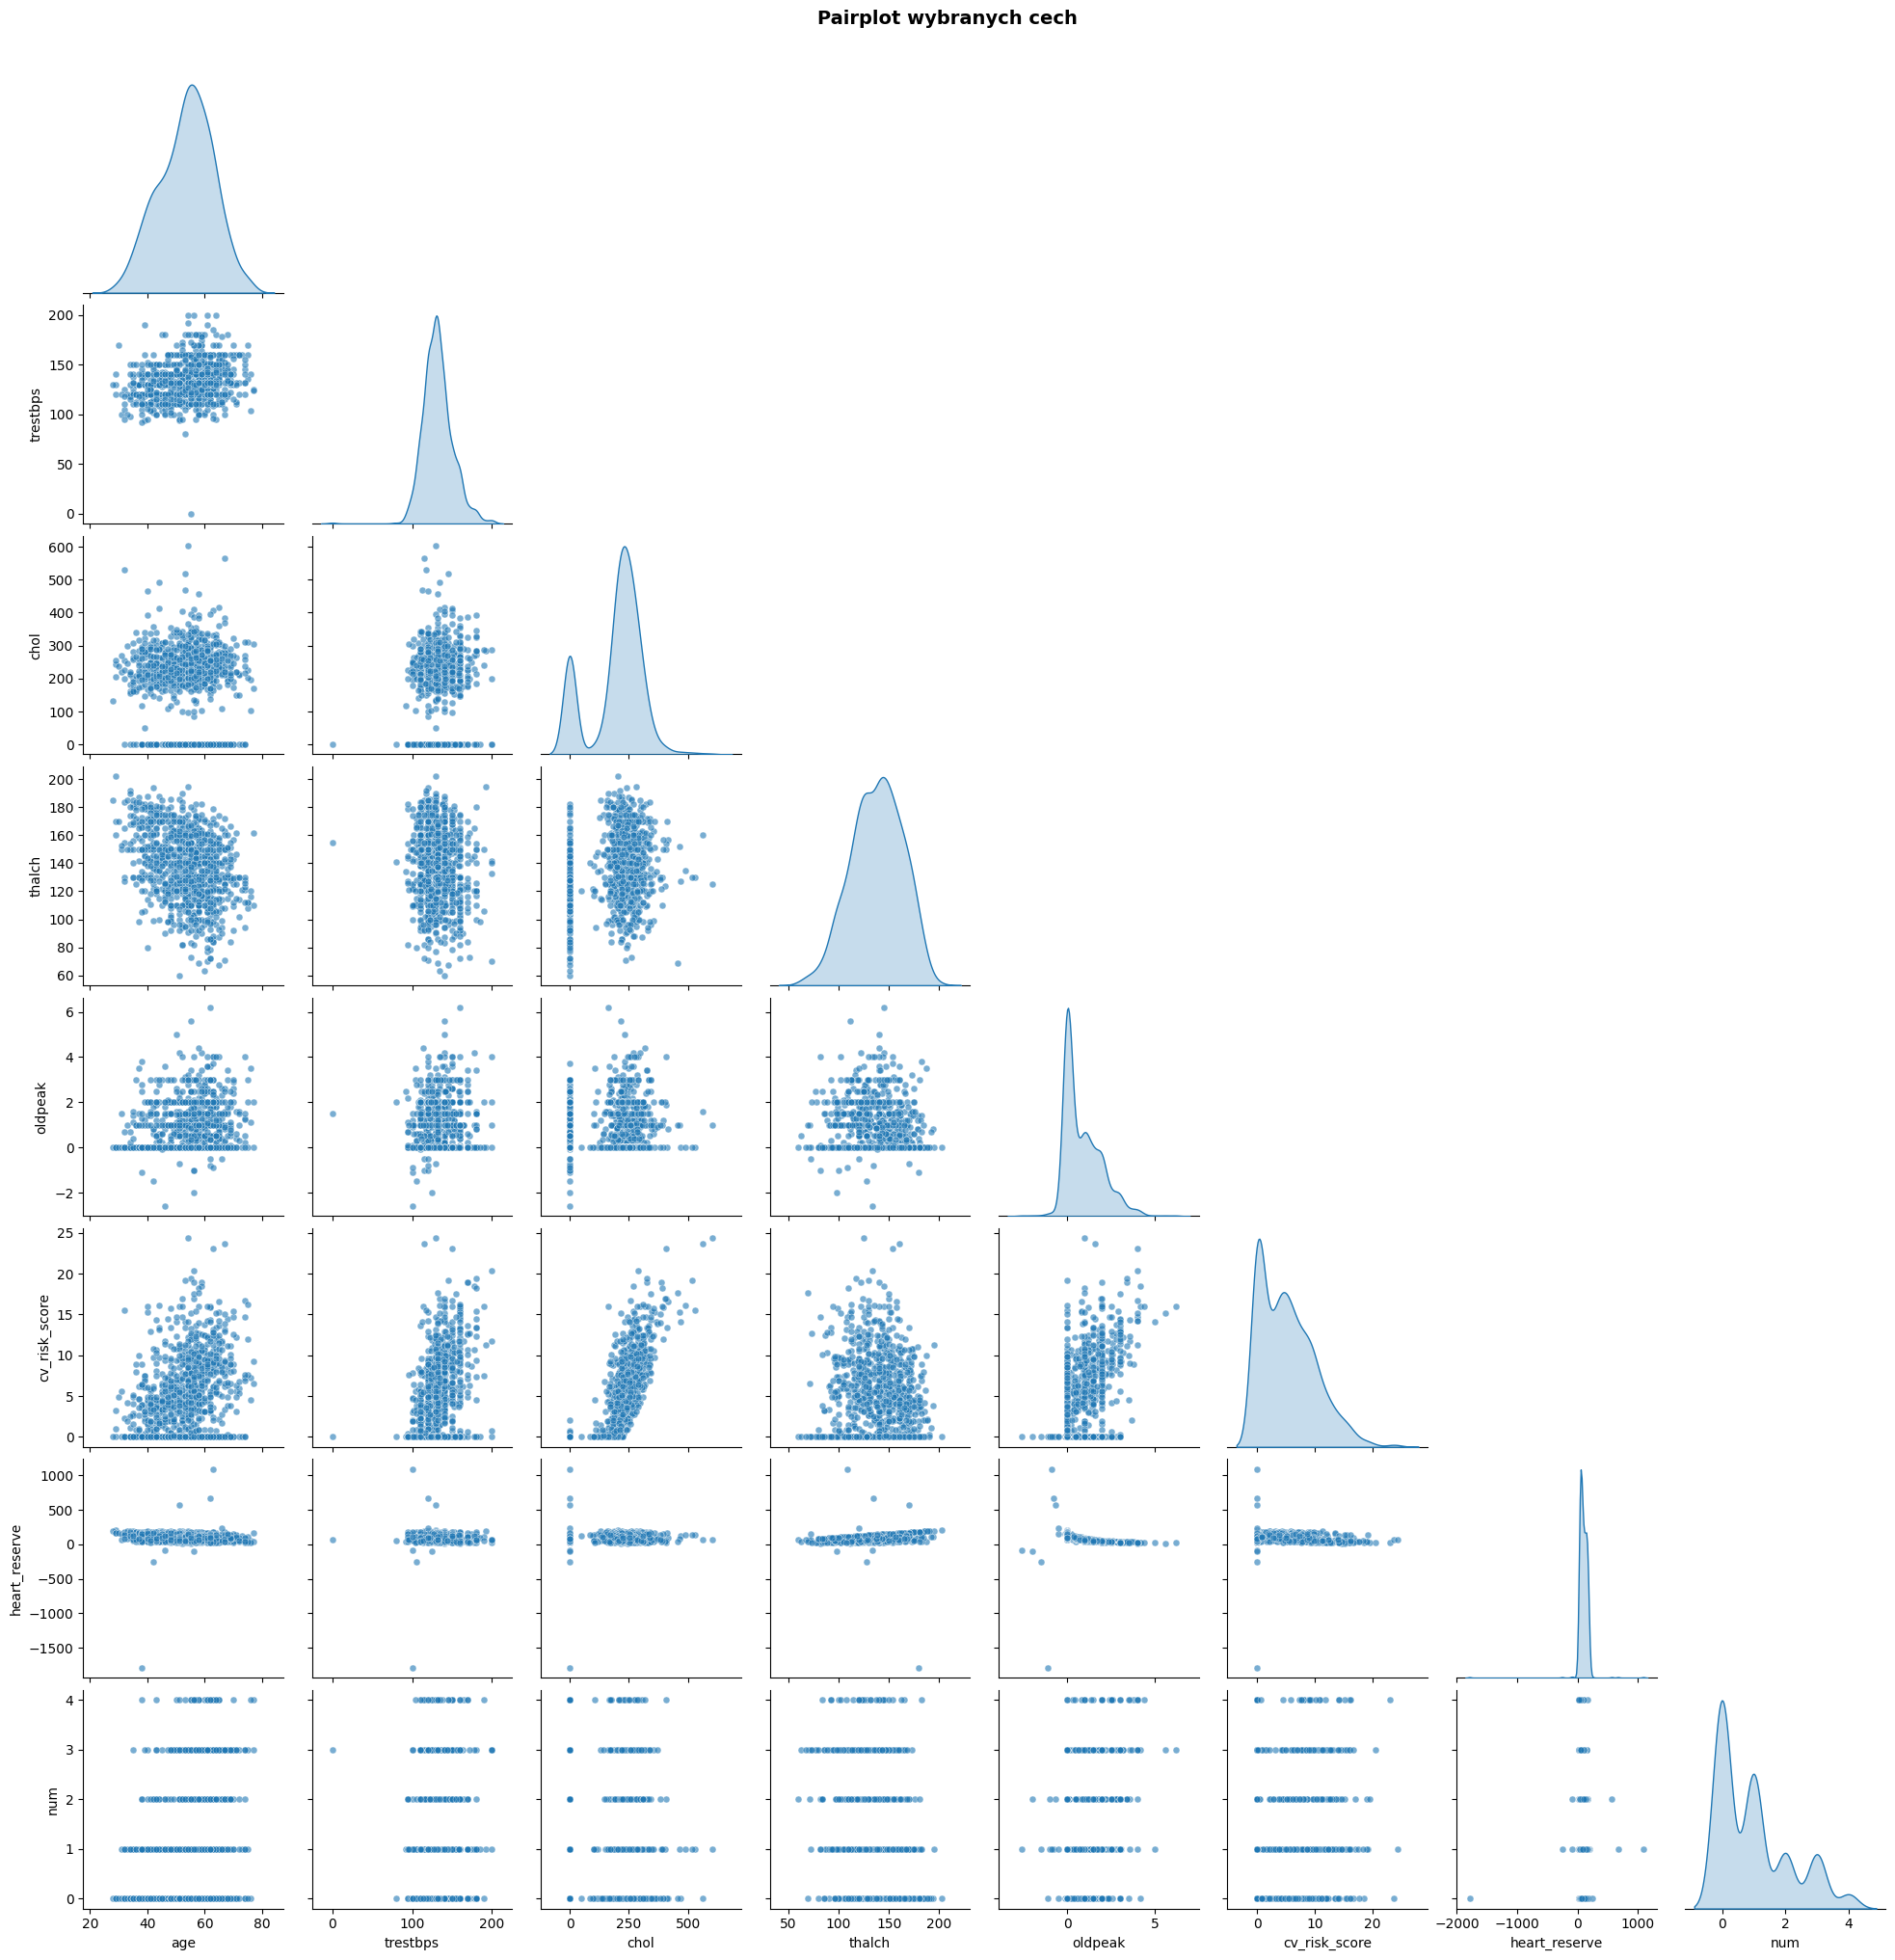

In [30]:
# 3.1.1 Pairplot wybranych cech
import seaborn as sns
import matplotlib.pyplot as plt

# Wybór najistotniejszych cech (w tym nowe cechy z feature engineering)
selected_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'cv_risk_score', 'heart_reserve']
selected_features = [c for c in selected_features if c in df_encoded.columns]

if len(selected_features) <= 8:
    sns.pairplot(
        df_encoded[selected_features + (['num'] if 'num' in df_encoded.columns else [])],
        diag_kind='kde', corner=True, plot_kws={'alpha': 0.6, 's': 25}
    )
    plt.suptitle("Pairplot wybranych cech", y=1.02, fontsize=14, fontweight='bold')
    plt.show()
else:
    print("Zbyt wiele cech do pairplotu — zmniejsz liczbę w selected_features.")



=== Korelacja Pearsona (wybrane cechy) ===


,age,trestbps,chol,thalch,oldpeak,cv_risk_score,heart_reserve
age,1.00,0.24,-0.09,-0.35,0.24,0.27,-0.14
trestbps,0.24,1.00,0.09,-0.10,0.16,0.39,-0.05
chol,-0.09,0.09,1.00,0.24,0.05,0.76,0.07
thalch,-0.35,-0.10,0.24,1.00,-0.15,-0.02,0.25
oldpeak,0.24,0.16,0.05,-0.15,1.00,0.50,-0.41
cv_risk_score,0.27,0.39,0.76,-0.02,0.50,1.00,-0.20
heart_reserve,-0.14,-0.05,0.07,0.25,-0.41,-0.20,1.00


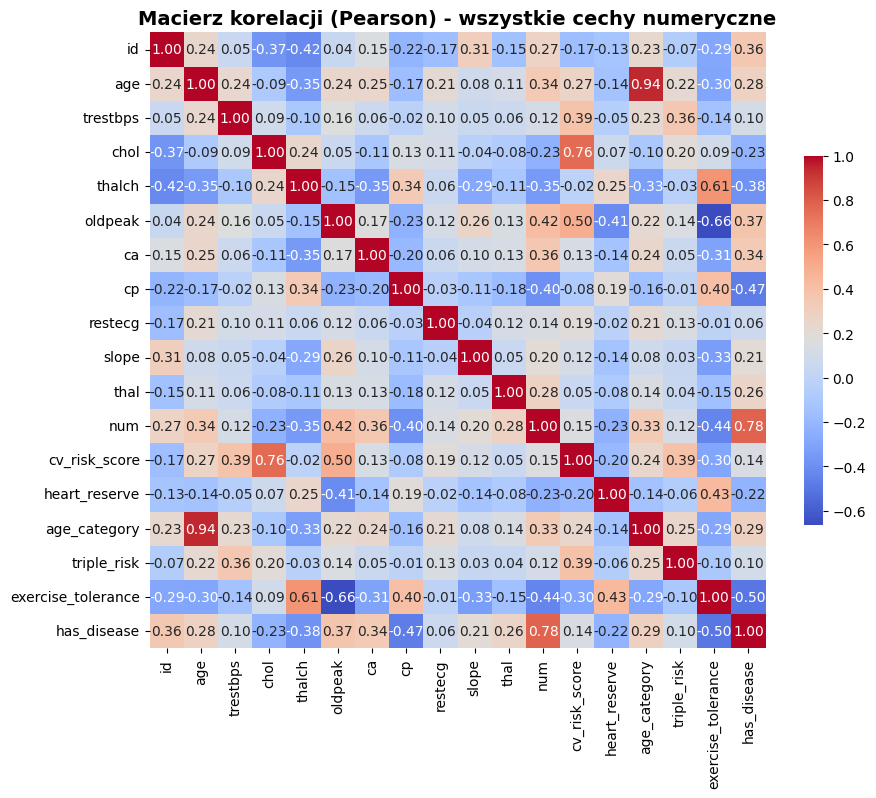

In [31]:
# 3.1.2 Korelacja Pearsona

# Wybór tylko kolumn numerycznych
num_cols = df_encoded.select_dtypes(include=['number']).columns.tolist()
pearson_corr = df_encoded[num_cols].corr(method='pearson')

print("\n=== Korelacja Pearsona (wybrane cechy) ===")
display(pearson_corr.loc[selected_features, selected_features].round(2))

plt.figure(figsize=(10, 8))
sns.heatmap(
    pearson_corr, annot=True, fmt=".2f", cmap="coolwarm",
    square=True, cbar_kws={'shrink': .6}
)
plt.title("Macierz korelacji (Pearson) - wszystkie cechy numeryczne", fontsize=14, fontweight='bold')
plt.show()



=== Korelacja Spearmana (wybrane cechy) ===


,age,trestbps,chol,thalch,oldpeak,cv_risk_score,heart_reserve
age,1.00,0.26,-0.04,-0.33,0.28,0.25,-0.35
trestbps,0.26,1.00,0.09,-0.09,0.17,0.38,-0.16
chol,-0.04,0.09,1.00,0.18,0.05,0.81,0.05
thalch,-0.33,-0.09,0.18,1.00,-0.19,0.01,0.53
oldpeak,0.28,0.17,0.05,-0.19,1.00,0.43,-0.90
cv_risk_score,0.25,0.38,0.81,0.01,0.43,1.00,-0.35
heart_reserve,-0.35,-0.16,0.05,0.53,-0.90,-0.35,1.00


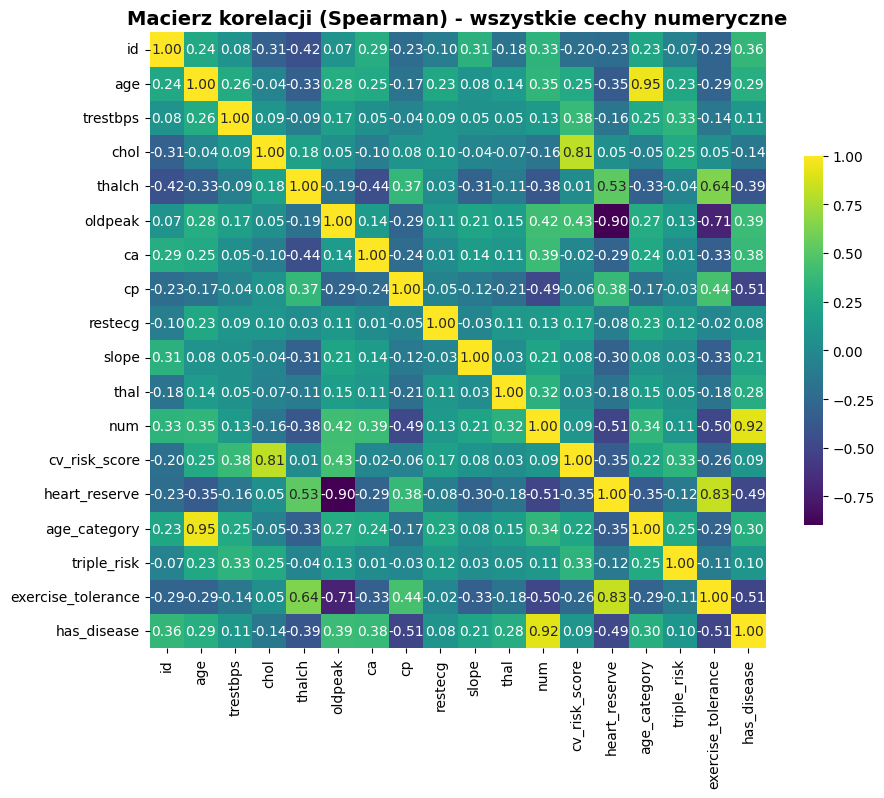

In [32]:
# 3.1.3 Korelacja Spearmana

spearman_corr = df_encoded[num_cols].corr(method='spearman')

print("\n=== Korelacja Spearmana (wybrane cechy) ===")
display(spearman_corr.loc[selected_features, selected_features].round(2))

# Wizualizacja macierzy Spearmana
plt.figure(figsize=(10, 8))
sns.heatmap(
    spearman_corr, annot=True, fmt=".2f", cmap="viridis",
    square=True, cbar_kws={'shrink': .6}
)
plt.title("Macierz korelacji (Spearman) - wszystkie cechy numeryczne", fontsize=14, fontweight='bold')
plt.show()


In [34]:
# =============================================================================
# 3.3.1 Detekcja wartości odstających metodą IQR
# =============================================================================
import numpy as np

# Wybór kolumn numerycznych do analizy
numeric_for_outliers = [
    c for c in df_encoded.select_dtypes(include=['float64', 'int64']).columns
    if c not in ('id', 'num', 'has_disease')
]

# Funkcja pomocnicza (IQR)
def detect_iqr_outliers(series, k=1.5):
    q1, q3 = series.quantile(0.25), series.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k * iqr, q3 + k * iqr
    return (series < lower) | (series > upper)

# Liczenie liczby outlierów w każdej kolumnie
outlier_counts = {
    col: int(detect_iqr_outliers(df_encoded[col].dropna()).sum())
    for col in numeric_for_outliers
}

print("Liczba wykrytych wartości odstających (IQR k=1.5):")
for col, cnt in sorted(outlier_counts.items(), key=lambda x: -x[1])[:15]:
    print(f"  {col}: {cnt}")


Liczba wykrytych wartości odstających (IQR k=1.5):
  slope: 266
  chol: 184
  triple_risk: 49
  cp: 46
  trestbps: 28
  ca: 21
  oldpeak: 16
  heart_reserve: 6
  cv_risk_score: 4
  thalch: 2
  age: 0
  restecg: 0
  thal: 0
  age_category: 0
  exercise_tolerance: 0


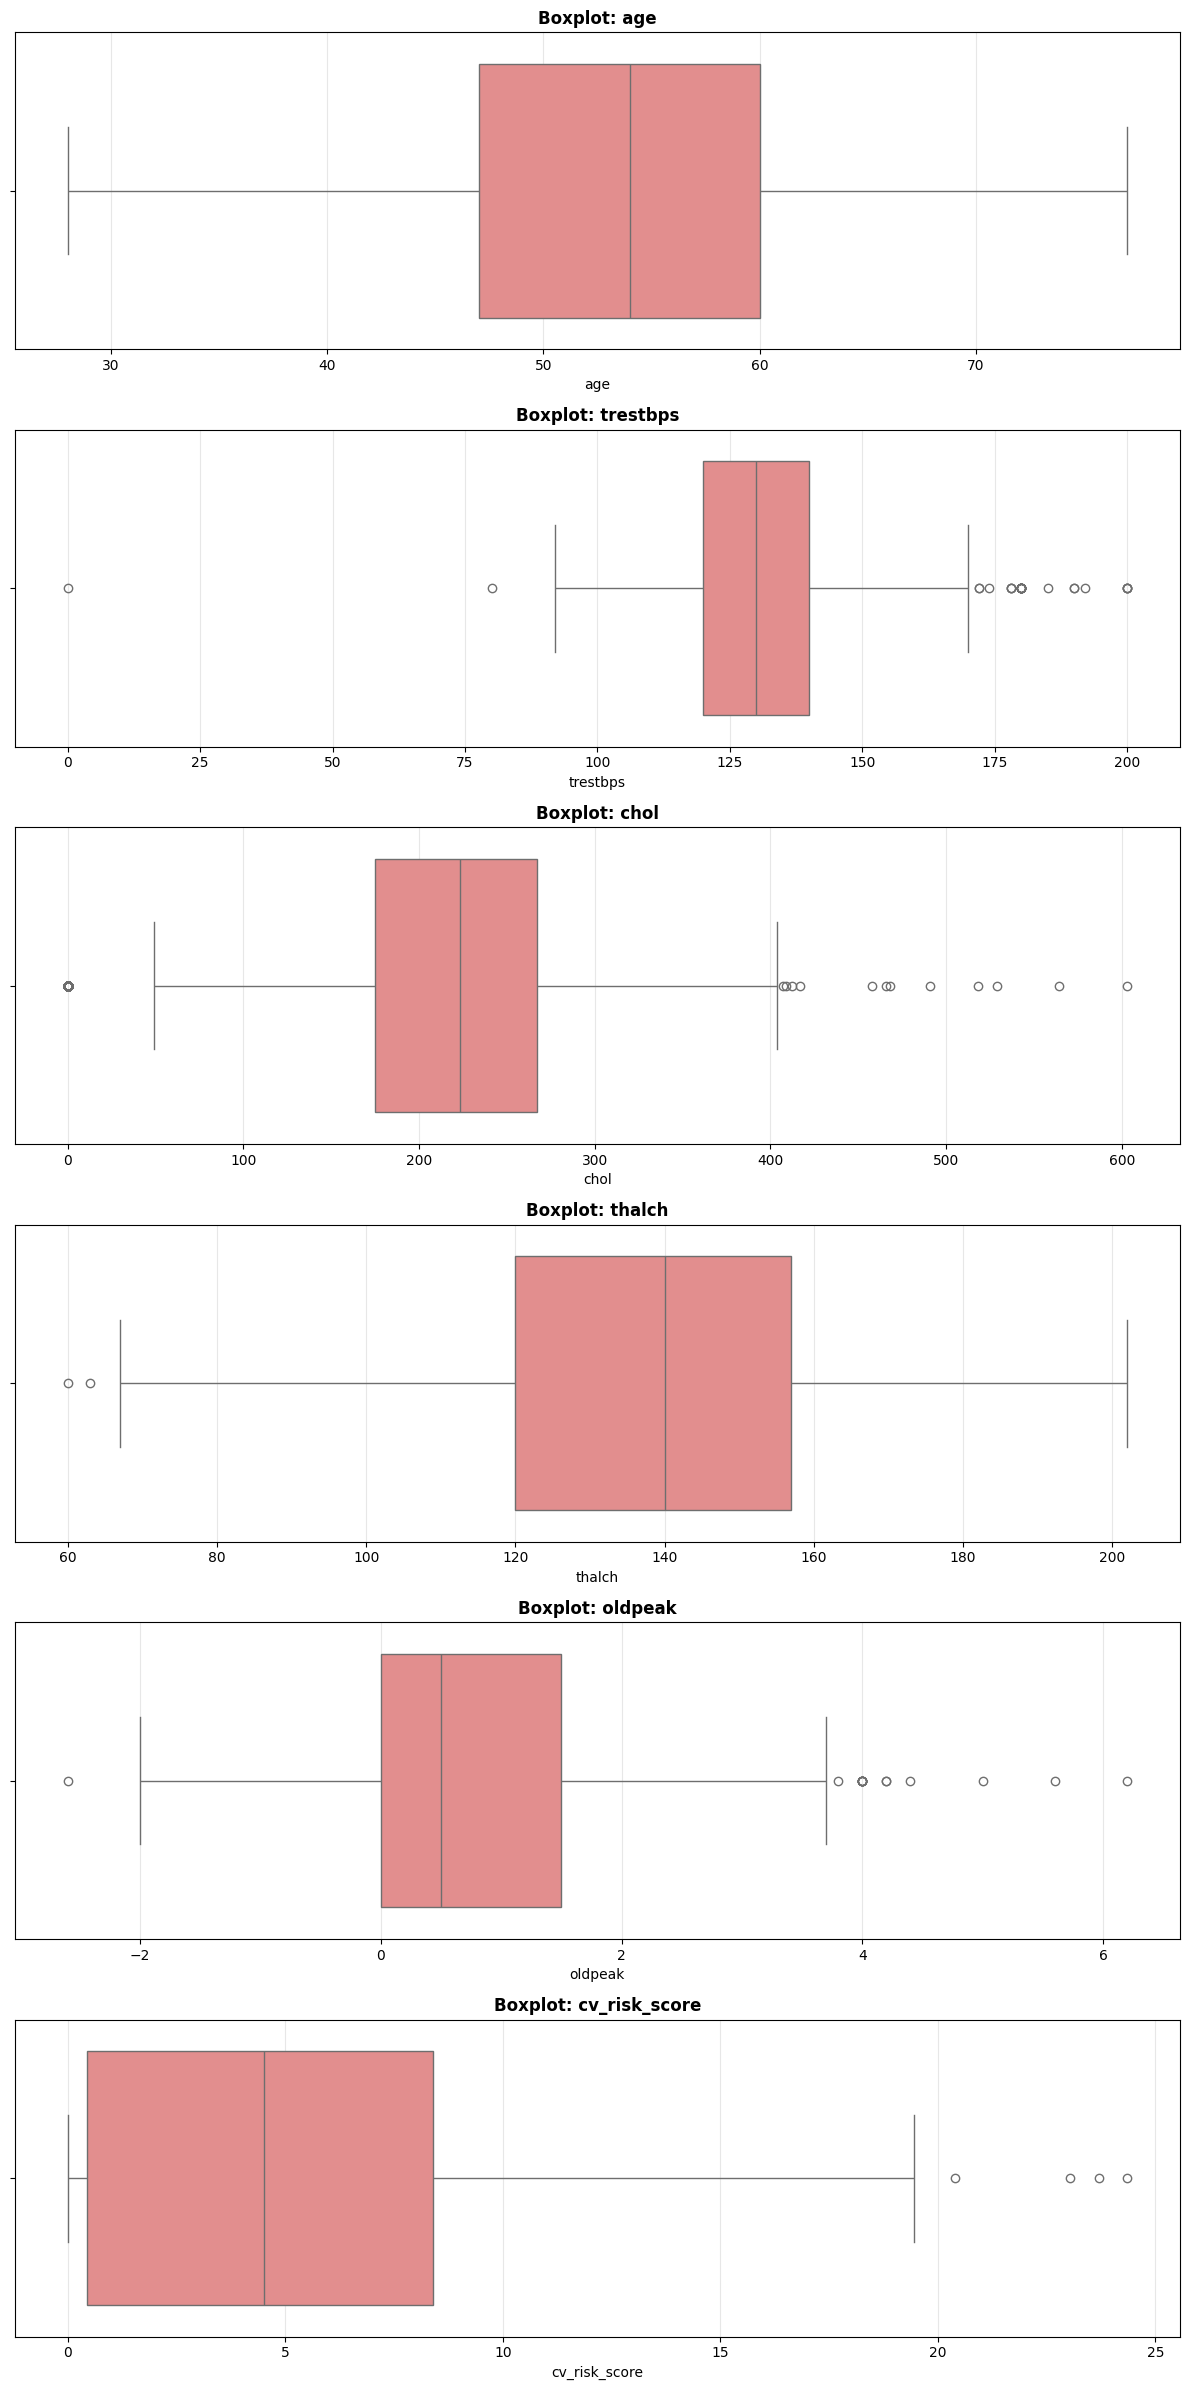

In [35]:
# 3.3.2 Wizualizacja boxplotów dla kluczowych cech
import seaborn as sns
import matplotlib.pyplot as plt

boxplot_cols = [c for c in ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'cv_risk_score']
                if c in df_encoded.columns]

if boxplot_cols:
    plt.figure(figsize=(12, 4 * len(boxplot_cols)))
    for i, col in enumerate(boxplot_cols, 1):
        plt.subplot(len(boxplot_cols), 1, i)
        sns.boxplot(x=df_encoded[col].replace([np.inf, -np.inf], np.nan), color='lightcoral')
        plt.title(f'Boxplot: {col}', fontsize=12, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [36]:
# =============================================================================
# 3.3.3 Opcjonalne czyszczenie outlierów
# =============================================================================

# 1️⃣ Usunięcie rekordów zawierających outlier w dowolnej analizowanej kolumnie
# df_no_outliers = df_encoded[
#     ~pd.concat([detect_iqr_outliers(df_encoded[c]) for c in boxplot_cols], axis=1).any(axis=1)
# ]

# 2️⃣ Winsoryzacja (przycięcie do granic 1.5*IQR)
# for c in boxplot_cols:
#     s = df_encoded[c]
#     q1, q3 = s.quantile(0.25), s.quantile(0.75)
#     iqr = q3 - q1
#     lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
#     df_encoded[c] = s.clip(lower, upper)

# ⚠️ Uwaga: W praktyce lepiej najpierw przeanalizować, czy outliery są rzeczywiste,
#           czy wynikają z błędu pomiaru. Nie usuwaj ich automatycznie.


In [37]:
!pip install pycaret[full]

In [39]:
# 3.4A PyCaret - automatyczne przetwarzanie i imputacja
# Uwaga: zainstaluj pycaret w środowisku przed uruchomieniem:
# !pip install pycaret[full]

from pycaret.classification import setup as pyc_setup, finalize_model, get_config
import pandas as pd

# Przygotuj kopię danych do imputacji (zachowaj oryginał)
df_py = df_encoded.copy()

# PyCaret expects target column name; upewnij się, że 'num' jest targetem i typ int
df_py['num'] = df_py['num'].astype(int)

# uruchom setup z imputacją 'simple' lub 'knn' — pycaret automatycznie obsłuży brakujące
s = pyc_setup(data=df_py, target='num', silent=True, html=False, session_id=42,
              imputation_type='simple')  # lub 'iterative' / 'knn' zależnie od wersji PyCaret

# Po setup pycaret przeprowadza preprocessing — odczytaj przetworzone dane:
processed = get_config('X')  # features po preprocessing
processed_y = get_config('y')

# Połącz z targetem (jeśli chcesz plik z imputacją)
df_py_imputed = pd.concat([processed.reset_index(drop=True), processed_y.reset_index(drop=True)], axis=1)
print("PyCaret finished. Shape:", df_py_imputed.shape)


RuntimeError: ('Pycaret only supports python 3.9, 3.10, 3.11. Your actual Python version: ', sys.version_info(major=3, minor=12, micro=12, releaselevel='final', serial=0), 'Please DOWNGRADE your Python version.')

#ALTERNATYWNIE

In [40]:
# 3.4B IterativeImputer (fallback / alternatywa)
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

df_iter = df_encoded.copy()

# Wybierz tylko kolumny numeryczne do imputacji (oraz zachowaj target osobno)
num_cols_for_impute = df_iter.select_dtypes(include=['float64','int64']).columns.tolist()
exclude = ['id']  # ew. exclude target if want to keep separate
num_cols_for_impute = [c for c in num_cols_for_impute if c not in exclude]

iter_imp = IterativeImputer(random_state=0, max_iter=10, sample_posterior=False)
df_iter_num = pd.DataFrame(iter_imp.fit_transform(df_iter[num_cols_for_impute]), columns=num_cols_for_impute, index=df_iter.index)

# Zastąp numeryczne kolumny imputowanymi
df_iter.loc[:, num_cols_for_impute] = df_iter_num
print("IterativeImputer done. Any NaNs left:", df_iter[num_cols_for_impute].isna().sum().sum())


IterativeImputer done. Any NaNs left: 0


#Krok 3.5 — Przygotowanie 4 metod imputacji + 2 skalowania → 8 datasetów

4 metody imputacji:

  *mean (SimpleImputer(strategy='mean')) — łatwy

  *median (SimpleImputer(strategy='median')) — łatwy

  *KNNImputer (n_neighbors=5) — trudniejszy/zaawansowany

  *IterativeImputer (lub PyCaret jeśli preferujesz) — automatyczny/trudniejszy

Dla każdego utworzymy dwie wersje: MinMax (manual) i Standard (Z-score manual)

In [ ]:
# Jeśli chcesz dokładnie 8: (tylko minmax i zscore)
datasets = {}
for imp_name, imp in imputers.items():
    df_tmp = df_encoded.copy()
    df_tmp_num = pd.DataFrame(imp.fit_transform(df_tmp[num_cols]), columns=num_cols, index=df_tmp.index)
    df_tmp.loc[:, num_cols] = df_tmp_num

    # MinMax
    df_mm = df_tmp.copy()
    for c in num_cols:
        arr = df_mm[c].astype(float)
        min_v = arr.min(); max_v = arr.max()
        df_mm[c] = 0.0 if max_v - min_v == 0 else (arr - min_v) / (max_v - min_v)
    datasets[f'{imp_name}_minmax'] = df_mm

    # Z-score
    df_z = df_tmp.copy()
    for c in num_cols:
        arr = df_z[c].astype(float)
        mean_v = arr.mean(); std_v = arr.std(ddof=0)
        df_z[c] = 0.0 if std_v == 0 else (arr - mean_v) / std_v
    datasets[f'{imp_name}_zscore'] = df_z

print("Stworzono dokładnie 8 datasetów:")
for k in sorted(datasets.keys()):
    print(" -", k, "shape:", datasets[k].shape)

In [ ]:
for name, df_d in datasets.items():
    numcols = [c for c in df_d.select_dtypes(include=['float64','int64']).columns if c not in ('id',)]
    nan_count = df_d[numcols].isna().sum().sum()
    print(name, "| shape:", df_d.shape, "| NaNs:", nan_count)
    # Możesz też policzyć avg correlation with target (jeśli 'num' is present)
    if 'num' in df_d.columns:
        corr_with_target = df_d[numcols + ['num']].corr()['num'].drop('num')
        print(" top corrs with num:")
        print(corr_with_target.abs().sort_values(ascending=False).head(5).round(2))
    print("-"*50)
